<a href="https://colab.research.google.com/github/Gopikanth123/deep_learning/blob/main/potato_leaf_desease_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [3]:
!kaggle datasets download -d arjuntejaswi/plant-village

 99% 326M/329M [00:10<00:00, 36.4MB/s]
100% 329M/329M [00:10<00:00, 33.8MB/s]


In [4]:
!unzip plant-village.zip

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-7476153023ce___YLCV_GCREC 2258.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Cur

In [5]:
%rm -rf /content/PlantVillage/.ipynb_checkpoints

In [6]:
%rm -rf /content/PlantVillage/Pepper__bell___Bacterial_spot

In [7]:
%rm -rf /content/PlantVillage/Pepper__bell___healthy

In [8]:
%rm -rf /content/PlantVillage/Tomato_Bacterial_spot

In [9]:
%rm -rf /content/PlantVillage/Tomato_Late_blight

In [10]:
%rm -rf /content/PlantVillage/Tomato_Leaf_Mold

In [11]:
%rm -rf /content/PlantVillage/Tomato_Septoria_leaf_spot

In [12]:
%rm -rf /content/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite

In [13]:
%rm -rf /content/PlantVillage/Tomato__Target_Spot

In [14]:
%rm -rf /content/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus

In [15]:
%rm -rf /content/PlantVillage/Tomato__Tomato_mosaic_virus

In [16]:
%rm -rf /content/PlantVillage/Tomato_healthy

In [17]:
%rm -rf /content/PlantVillage/Tomato_Early_blight

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [19]:
INPUT_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
n_classes = 3

In [20]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (INPUT_SIZE,INPUT_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [21]:
class_names = dataset.class_names

In [22]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

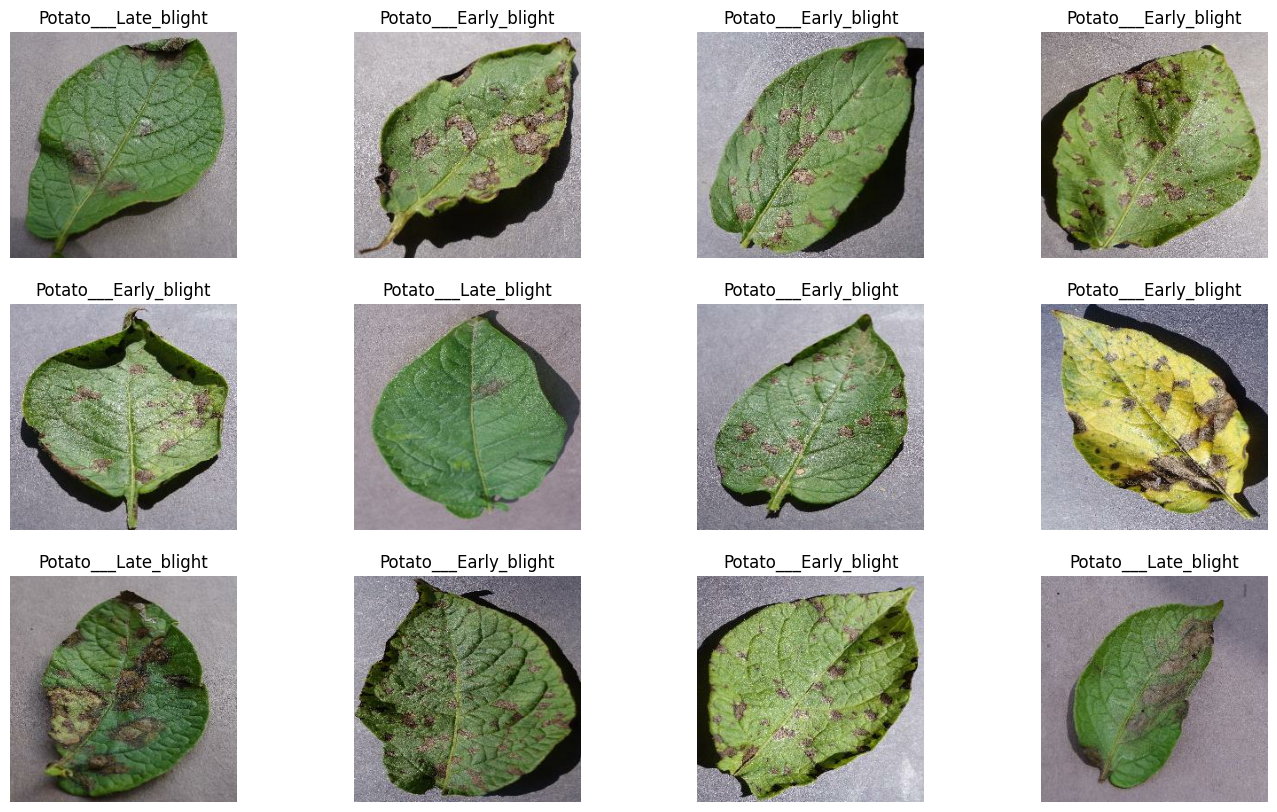

In [23]:
#visualitaion
plt.figure(figsize=(17,10))
for img_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    title = class_names[label_batch[i]]
    plt.title(title)
    plt.imshow(img_batch[i].numpy().astype("uint8"))
    plt.axis("off")

In [24]:
#splitting data into training and testing sets
#trainning = 80%
#validation = 10%
#testing = 10%

def get_dataset_partions(ds,train_split=0.8,test_size=0.1,validation_size=0.1,shuffle=True,shuffle_size = 10000):
  le = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=True)
  train_size = int(le*train_split)
  train_set = ds.take(train_size)
  test_set = ds.skip(train_size)
  vaildation_size = int(le*test_size)
  validation_set = test_set.take(vaildation_size)
  test_set = test_set.skip(vaildation_size)
  return train_set,validation_set,test_set

In [25]:
train_set,validation_set,test_set = get_dataset_partions(dataset)

In [26]:
len(train_set)

54

In [27]:
len(test_set)

8

In [28]:
len(validation_set)

6

In [29]:
#optimizing dataset performance using cache and prefetch functions
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
#Creating resize and scaling layers
resize_rescale = keras.Sequential([
    layers.experimental.preprocessing.Resizing(INPUT_SIZE,INPUT_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [31]:
#creating layers to encounter rotated images
data_augementation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [34]:
input_shape = (BATCH_SIZE,INPUT_SIZE,INPUT_SIZE,CHANNELS)
model = models.Sequential([
    resize_rescale,
    data_augementation,
    layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")
])
model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [36]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [42]:
# history = model.fit(
#     train_set,
#     epochs=10,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data = validation_set
# )

In [39]:
%%time
result = model.fit(
    train_set,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = validation_set
)


Epoch 1/10
54/54 [==============================] - 4s 69ms/step - loss: 0.3438 - accuracy: 0.8611 - val_loss: 0.4346 - val_accuracy: 0.8438
Epoch 2/10
54/54 [==============================] - 3s 59ms/step - loss: 0.2873 - accuracy: 0.8935 - val_loss: 0.2750 - val_accuracy: 0.8646
Epoch 3/10
54/54 [==============================] - 3s 61ms/step - loss: 0.2157 - accuracy: 0.9259 - val_loss: 0.1449 - val_accuracy: 0.9531
Epoch 4/10
54/54 [==============================] - 3s 60ms/step - loss: 0.2090 - accuracy: 0.9196 - val_loss: 0.3205 - val_accuracy: 0.8802
Epoch 5/10
54/54 [==============================] - 3s 61ms/step - loss: 0.1832 - accuracy: 0.9306 - val_loss: 0.1795 - val_accuracy: 0.9427
Epoch 6/10
54/54 [==============================] - 3s 60ms/step - loss: 0.1675 - accuracy: 0.9358 - val_loss: 0.0956 - val_accuracy: 0.9635
Epoch 7/10
54/54 [==============================] - 3s 60ms/step - loss: 0.1766 - accuracy: 0.9311 - val_loss: 0.1209 - val_accuracy: 0.9479
Epoch 8/10
54

In [40]:
score=model.evaluate(test_set)

8/8 [==============================] - 3s 28ms/step - loss: 0.1109 - accuracy: 0.9609


In [41]:
score

[0.1108827292919159, 0.9609375]

In [43]:
result

In [45]:
result.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [46]:
result.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [47]:
result.history['accuracy']

[0.8611111044883728,
 0.8935185074806213,
 0.9259259104728699,
 0.9195601940155029,
 0.9305555820465088,
 0.9357638955116272,
 0.9311342835426331,
 0.9456018805503845,
 0.9548611044883728,
 0.9479166865348816]

In [48]:
acc=result.history['accuracy']
val_acc=result.history['val_accuracy']

loss=result.history['loss']
val_loss=result.history['val_loss']

Text(0.5, 1.0, 'Training And Validation Loss')

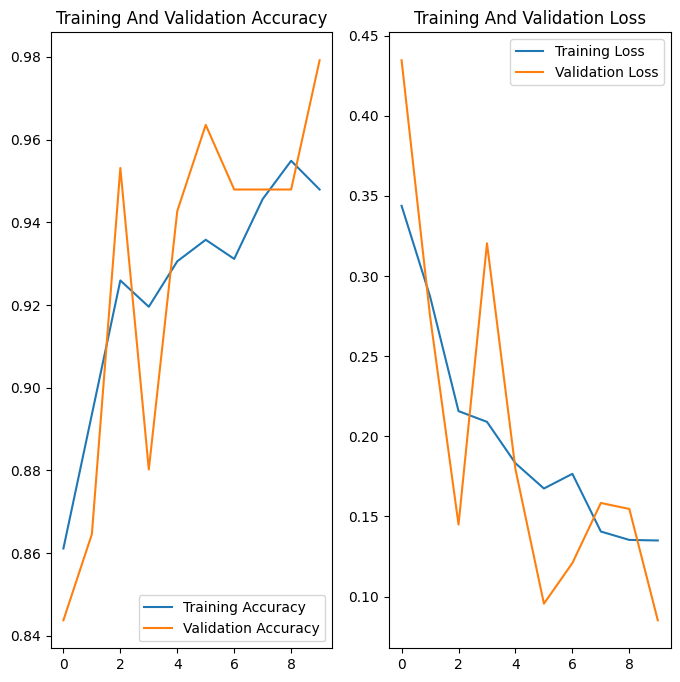

In [49]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(10),acc,label="Training Accuracy")
plt.plot(range(10),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training And Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(10),loss,label="Training Loss")
plt.plot(range(10),val_loss,label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training And Validation Loss")

In [51]:
model.save("/content/drive/MyDrive/Colab Notebooks/Saved Models/potatodisease.h5")

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 40ms/step
predicted label: Potato___Late_blight


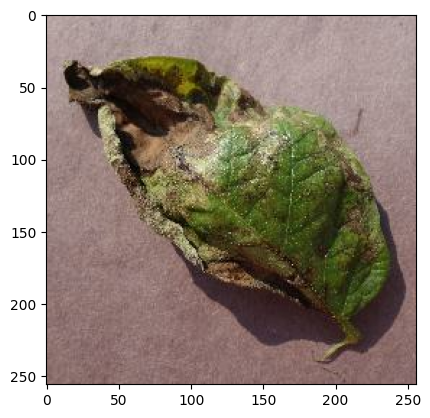

In [55]:
import numpy as np
for image_batch,label_batch in test_set.take(1):
  first_image=image_batch[0].numpy().astype('uint8')
  first_label=label_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:",class_names[first_label])

  batch_prediction = model.predict(image_batch,verbose=1)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [56]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


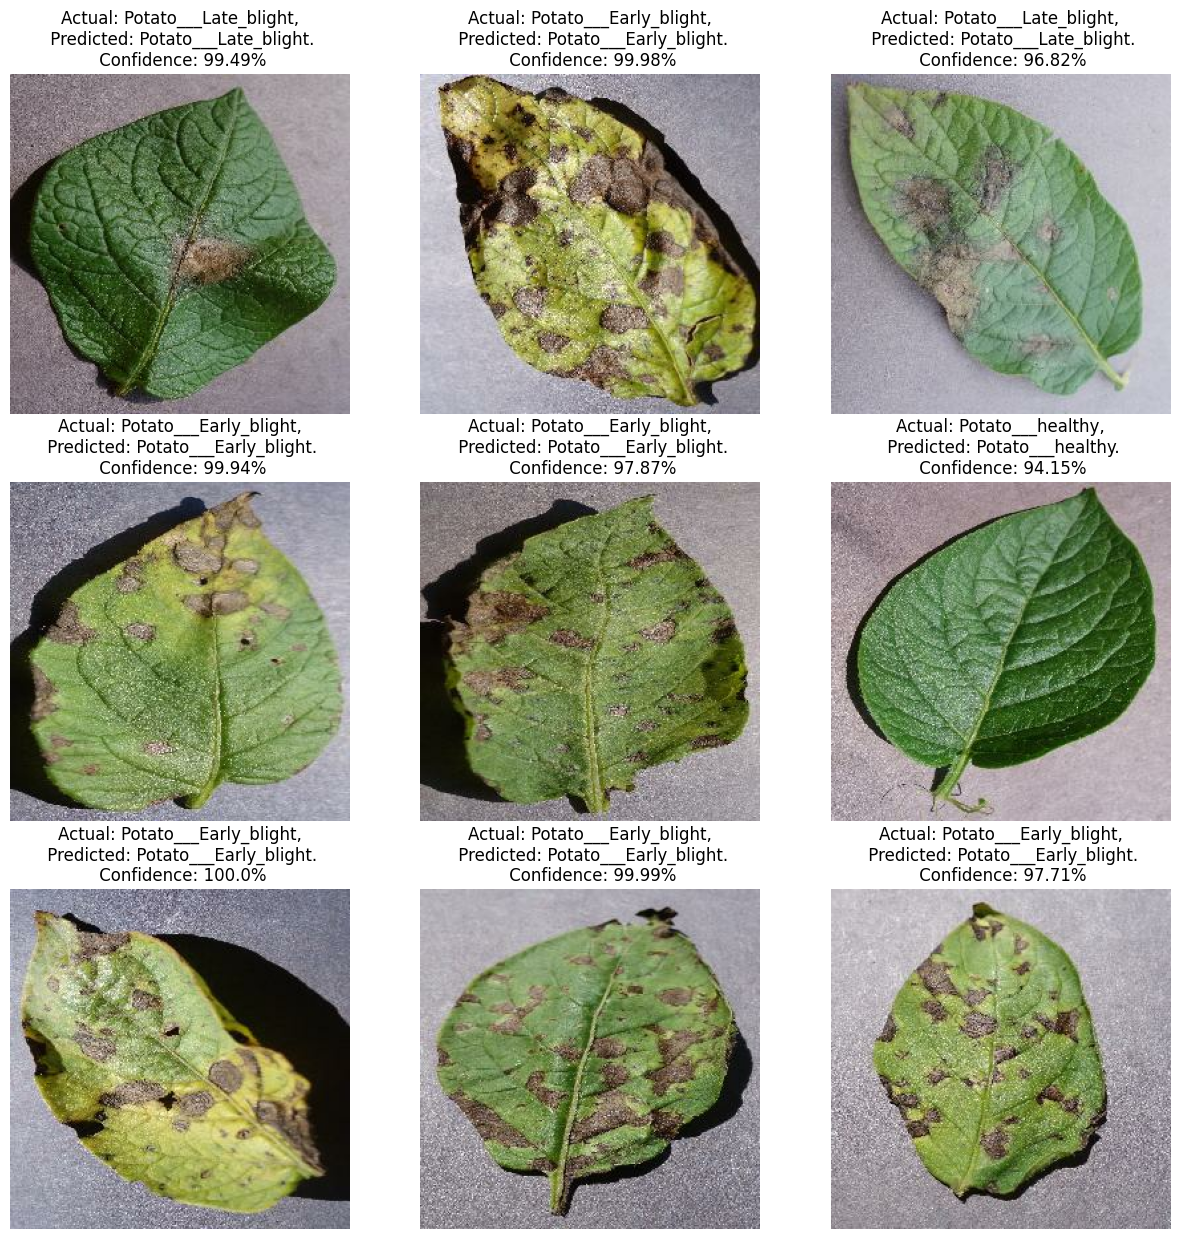

In [59]:
plt.figure(figsize=(15, 15))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")